In [ ]:
!pip install gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1ccH9YQxOgV3WVzjbVxg-scuT7F8iWq46  #dataset_02

Downloading...
From: https://drive.google.com/uc?id=1ccH9YQxOgV3WVzjbVxg-scuT7F8iWq46
To: /content/v_induced.mat
100% 2.81G/2.81G [00:14<00:00, 191MB/s]


In [ ]:
#!gdown 1DG2hmiAxijRSlMB9xTBYtVuyr8k0C9Xm

In [ ]:
!gdown 1jYBuW_iu5Z7O6YSJM3ypIWchEotHa8cd

Downloading...
From: https://drive.google.com/uc?id=1jYBuW_iu5Z7O6YSJM3ypIWchEotHa8cd
To: /content/str_point_fix.mat
100% 152k/152k [00:00<00:00, 57.6MB/s]


In [ ]:
!gdown 1-1kIceG7yx_iQobXhPkW-9jBrfBE0RhT

Downloading...
From: https://drive.google.com/uc?id=1-1kIceG7yx_iQobXhPkW-9jBrfBE0RhT
To: /content/best_localize_model.pth
100% 41.1M/41.1M [00:00<00:00, 59.1MB/s]


In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
torch.manual_seed(46)
torch.__version__

'2.0.0+cu118'

In [ ]:
#dataset_01 = scipy.io.loadmat('dataset_01.mat')
dataset_01 = scipy.io.loadmat('v_induced.mat')
str_point_fix = scipy.io.loadmat('str_point_fix.mat')

In [ ]:
plt.rc('font',size=11)

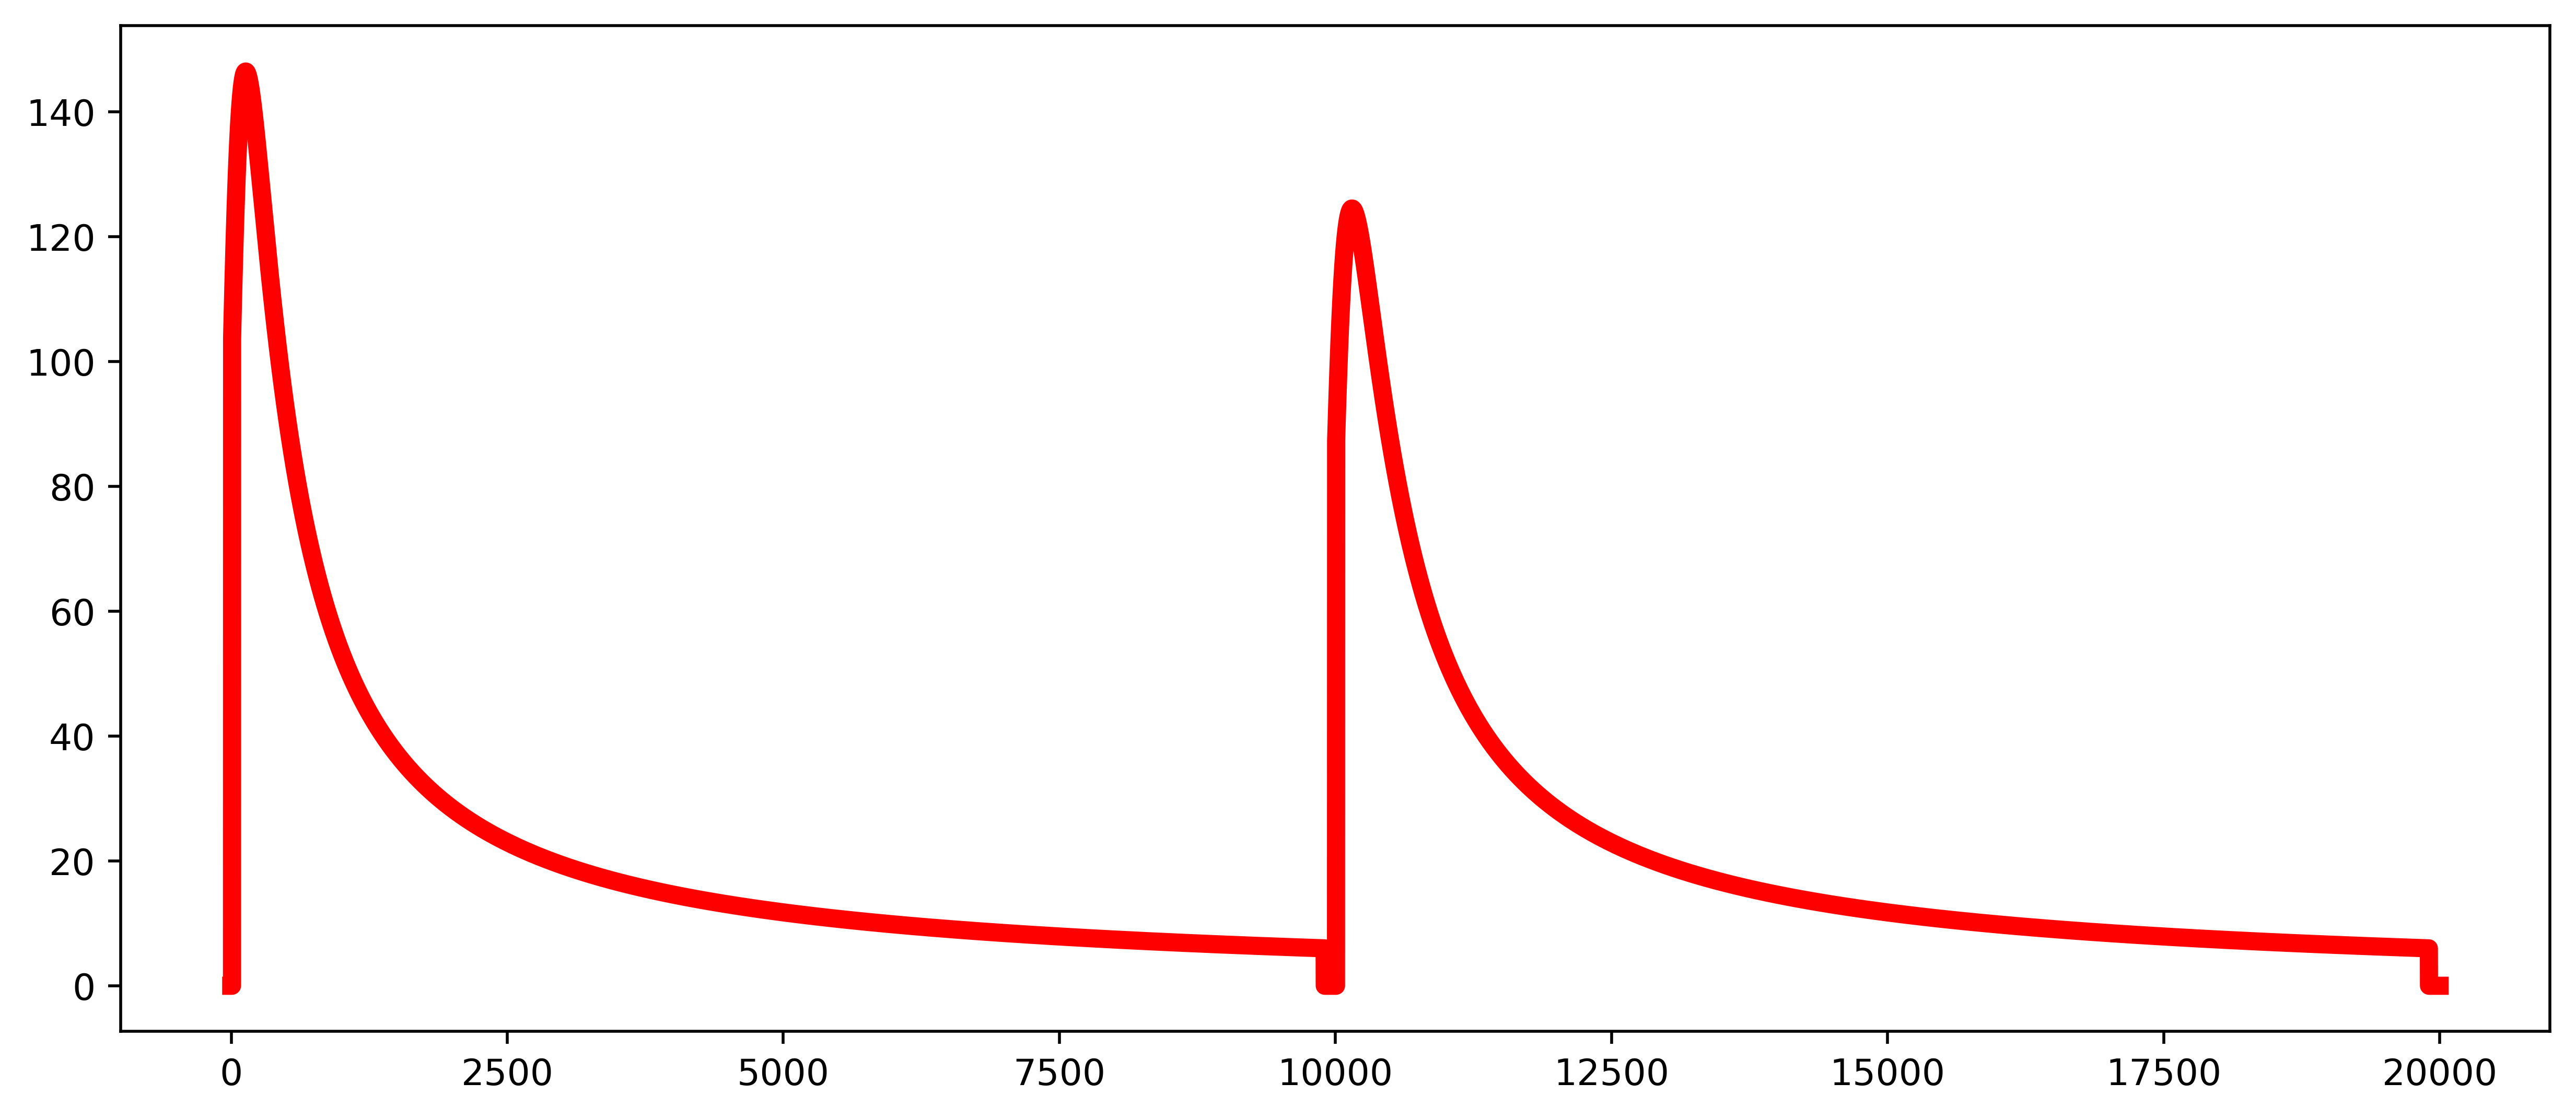

In [ ]:
plt.figure(figsize=(12,5),dpi=500,)
# plt.subplot(211)
# plt.plot(dataset_01['v_induced1'][4])
# plt.plot(dataset_01['v_induced3'][4])
# plt.ylabel("Induced voltage",fontsize=15)
# plt.xlabel("Time",fontsize=15)
# plt.text(4900, -35,"(a)",fontsize=18)
# plt.subplot(212)
plt.plot(np.concatenate((
                    dataset_01['v_induced1'][4],
                    #v2[:,np.newaxis,:],
                    dataset_01['v_induced3'][4],
                    #dataset_01['v_induced4'][:,np.newaxis,:]
                    ),axis=0),'r',linewidth=5)

# plt.ylabel("Induced voltage",fontsize=15)
# plt.xlabel("Time",fontsize=15)
#plt.text(2*4900, -35,"(b)",fontsize=18)


In [ ]:
target = np.concatenate((str_point_fix['x_str'].reshape((-1,1)),
                         str_point_fix['y_str'].reshape((-1,1))),axis=1)
# target = np.concatenate((preprocessing.normalize(str_point_fix_dataset_01['x_str']).reshape((-1,1)),
#                          preprocessing.normalize(str_point_fix_dataset_01['y_str']).reshape((-1,1))),axis=1)

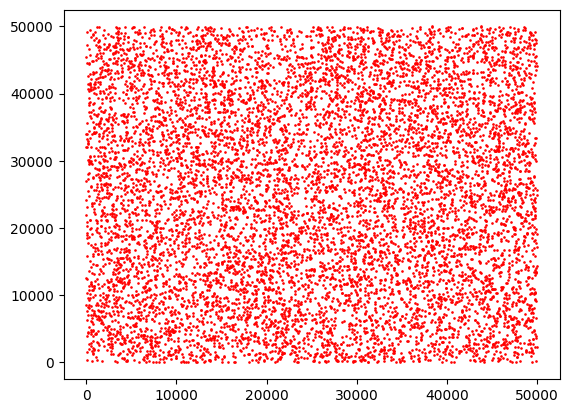

In [ ]:
plt.scatter(str_point_fix['x_str'],str_point_fix['y_str'],s=0.8,marker='o',c='r')

In [ ]:
v1 = preprocessing.normalize(dataset_01['v_induced1'])
#v2 = preprocessing.normalize(dataset_01['v_induced2'])
v3 = preprocessing.normalize(dataset_01['v_induced3'])
#v4 = preprocessing.normalize(dataset_01['v_induced4'])

In [ ]:
x = np.concatenate((
                    v1[:,np.newaxis,:],
                    #v2[:,np.newaxis,:],
                    v3[:,np.newaxis,:],
                    #dataset_01['v_induced4'][:,np.newaxis,:]
                    ),axis=2)

In [ ]:
del dataset_01

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, signals, labels):
    self.labels = labels
    self.signals = signals

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = self.labels[idx]
    signal = self.signals[idx]
    return signal, label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.2, random_state=46)
X_train.shape

(8000, 1, 20000)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)

In [ ]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

In [ ]:
train_dataloader = DataLoader(train_dataset, )
test_dataloader = DataLoader(test_dataset, )

In [ ]:
torch.manual_seed(46)
class Auto_Encoder(nn.Module):
    def __init__(self):
        super(Auto_Encoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Conv1d(1,4,4, ),
            nn.GELU(),
            nn.Conv1d(4,4,5,stride=2),
            nn.GELU(),
            nn.Conv1d(4,4,5,),
            nn.GELU(),



        )
        self.decoder = nn.Sequential(

            nn.ConvTranspose1d(4,4,5,),
            nn.GELU(),
            nn.ConvTranspose1d(4,4,5,stride=2),
            nn.GELU(),
            nn.ConvTranspose1d(4,1,4,),

        )
    def forward(self,x):
        encode = self.encoder(x)


        decode = self.decoder(encode)

        return encode, decode

model = Auto_Encoder().to(device)
print(model)

Auto_Encoder(
  (encoder): Sequential(
    (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(4, 4, kernel_size=(5,), stride=(2,))
    (3): GELU(approximate='none')
    (4): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (5): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(4, 4, kernel_size=(5,), stride=(1,))
    (1): GELU(approximate='none')
    (2): ConvTranspose1d(4, 4, kernel_size=(5,), stride=(2,))
    (3): GELU(approximate='none')
    (4): ConvTranspose1d(4, 1, kernel_size=(4,), stride=(1,))
  )
)


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001/2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

In [ ]:
def train(dataloader, model, loss_fn, oprimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()

    for batch , (X,y)  in enumerate(dataloader):

        _, pred = model(X.float())
        loss = loss_fn(pred, X.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%1000 ==0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()
    return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch , (X,y)  in enumerate(dataloader):
            _, pred = model(X.float())
            test_loss += loss_fn(pred, X.float()).item()
            #print(pred.argmax(0),y)
    test_loss /= num_batches
    print(f"Test Error:  Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
epochs = 130
train_losses, test_losses = [], []
for i in range(epochs):
    print(f"Epoch {i+1} \n" ,"-"*15)
    train_loss=train(train_dataloader, model, loss_fn, optimizer, exp_lr_scheduler)
    test_loss=test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss.to("cpu").detach().numpy())
    test_losses.append(test_loss)
    if test_loss <= min(test_losses):
      torch.save(model.state_dict(), 'best_autoencoder_model.pth')
      print("Saved PyTorch Model State to best_autoencoder_model.pth")

Epoch 1 
 ---------------
loss: 0.053035  [    0/ 8000]
loss: 0.000019  [ 1000/ 8000]
loss: 0.000040  [ 2000/ 8000]
loss: 0.000012  [ 3000/ 8000]
loss: 0.000011  [ 4000/ 8000]
loss: 0.000009  [ 5000/ 8000]
loss: 0.000008  [ 6000/ 8000]
loss: 0.000007  [ 7000/ 8000]
Test Error:  Avg loss: 0.000006 

Saved PyTorch Model State to best_autoencoder_model.pth
Epoch 2 
 ---------------
loss: 0.000008  [    0/ 8000]
loss: 0.000004  [ 1000/ 8000]
loss: 0.000025  [ 2000/ 8000]
loss: 0.000004  [ 3000/ 8000]
loss: 0.000001  [ 4000/ 8000]
loss: 0.000001  [ 5000/ 8000]
loss: 0.000000  [ 6000/ 8000]
loss: 0.000000  [ 7000/ 8000]
Test Error:  Avg loss: 0.000001 

Saved PyTorch Model State to best_autoencoder_model.pth
Epoch 3 
 ---------------
loss: 0.000001  [    0/ 8000]
loss: 0.000000  [ 1000/ 8000]
loss: 0.000016  [ 2000/ 8000]
loss: 0.000001  [ 3000/ 8000]
loss: 0.000000  [ 4000/ 8000]
loss: 0.000000  [ 5000/ 8000]
loss: 0.000000  [ 6000/ 8000]
loss: 0.000000  [ 7000/ 8000]
Test Error:  Avg loss:

Text(0.5, 1.0, 'AutoEncoder Model Loss')

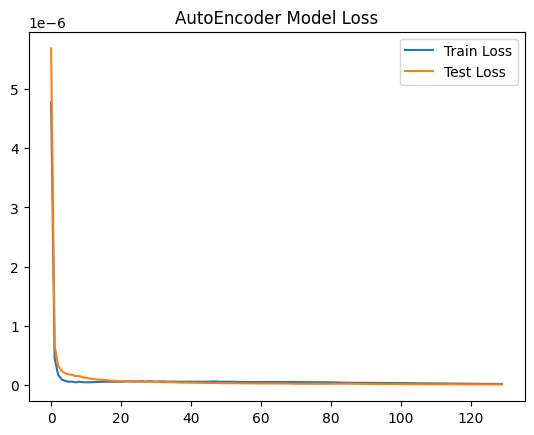

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["Train Loss", "Test Loss"])
plt.title("AutoEncoder Model Loss")

In [ ]:
model.load_state_dict(torch.load("best_autoencoder_model.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
testx,testy=next(iter(test_dataloader))

In [ ]:
pred = model(testx.float())[1].to("cpu").detach().numpy()[0]

In [ ]:
print(np.corrcoef(pred,testx.to("cpu").detach().numpy()[0])[0][1])

0.9998800653600073


In [ ]:
encode = model(testx.float())[0].to("cpu").detach().numpy()[0]

In [ ]:
encode.reshape(-1,).shape

(39972,)

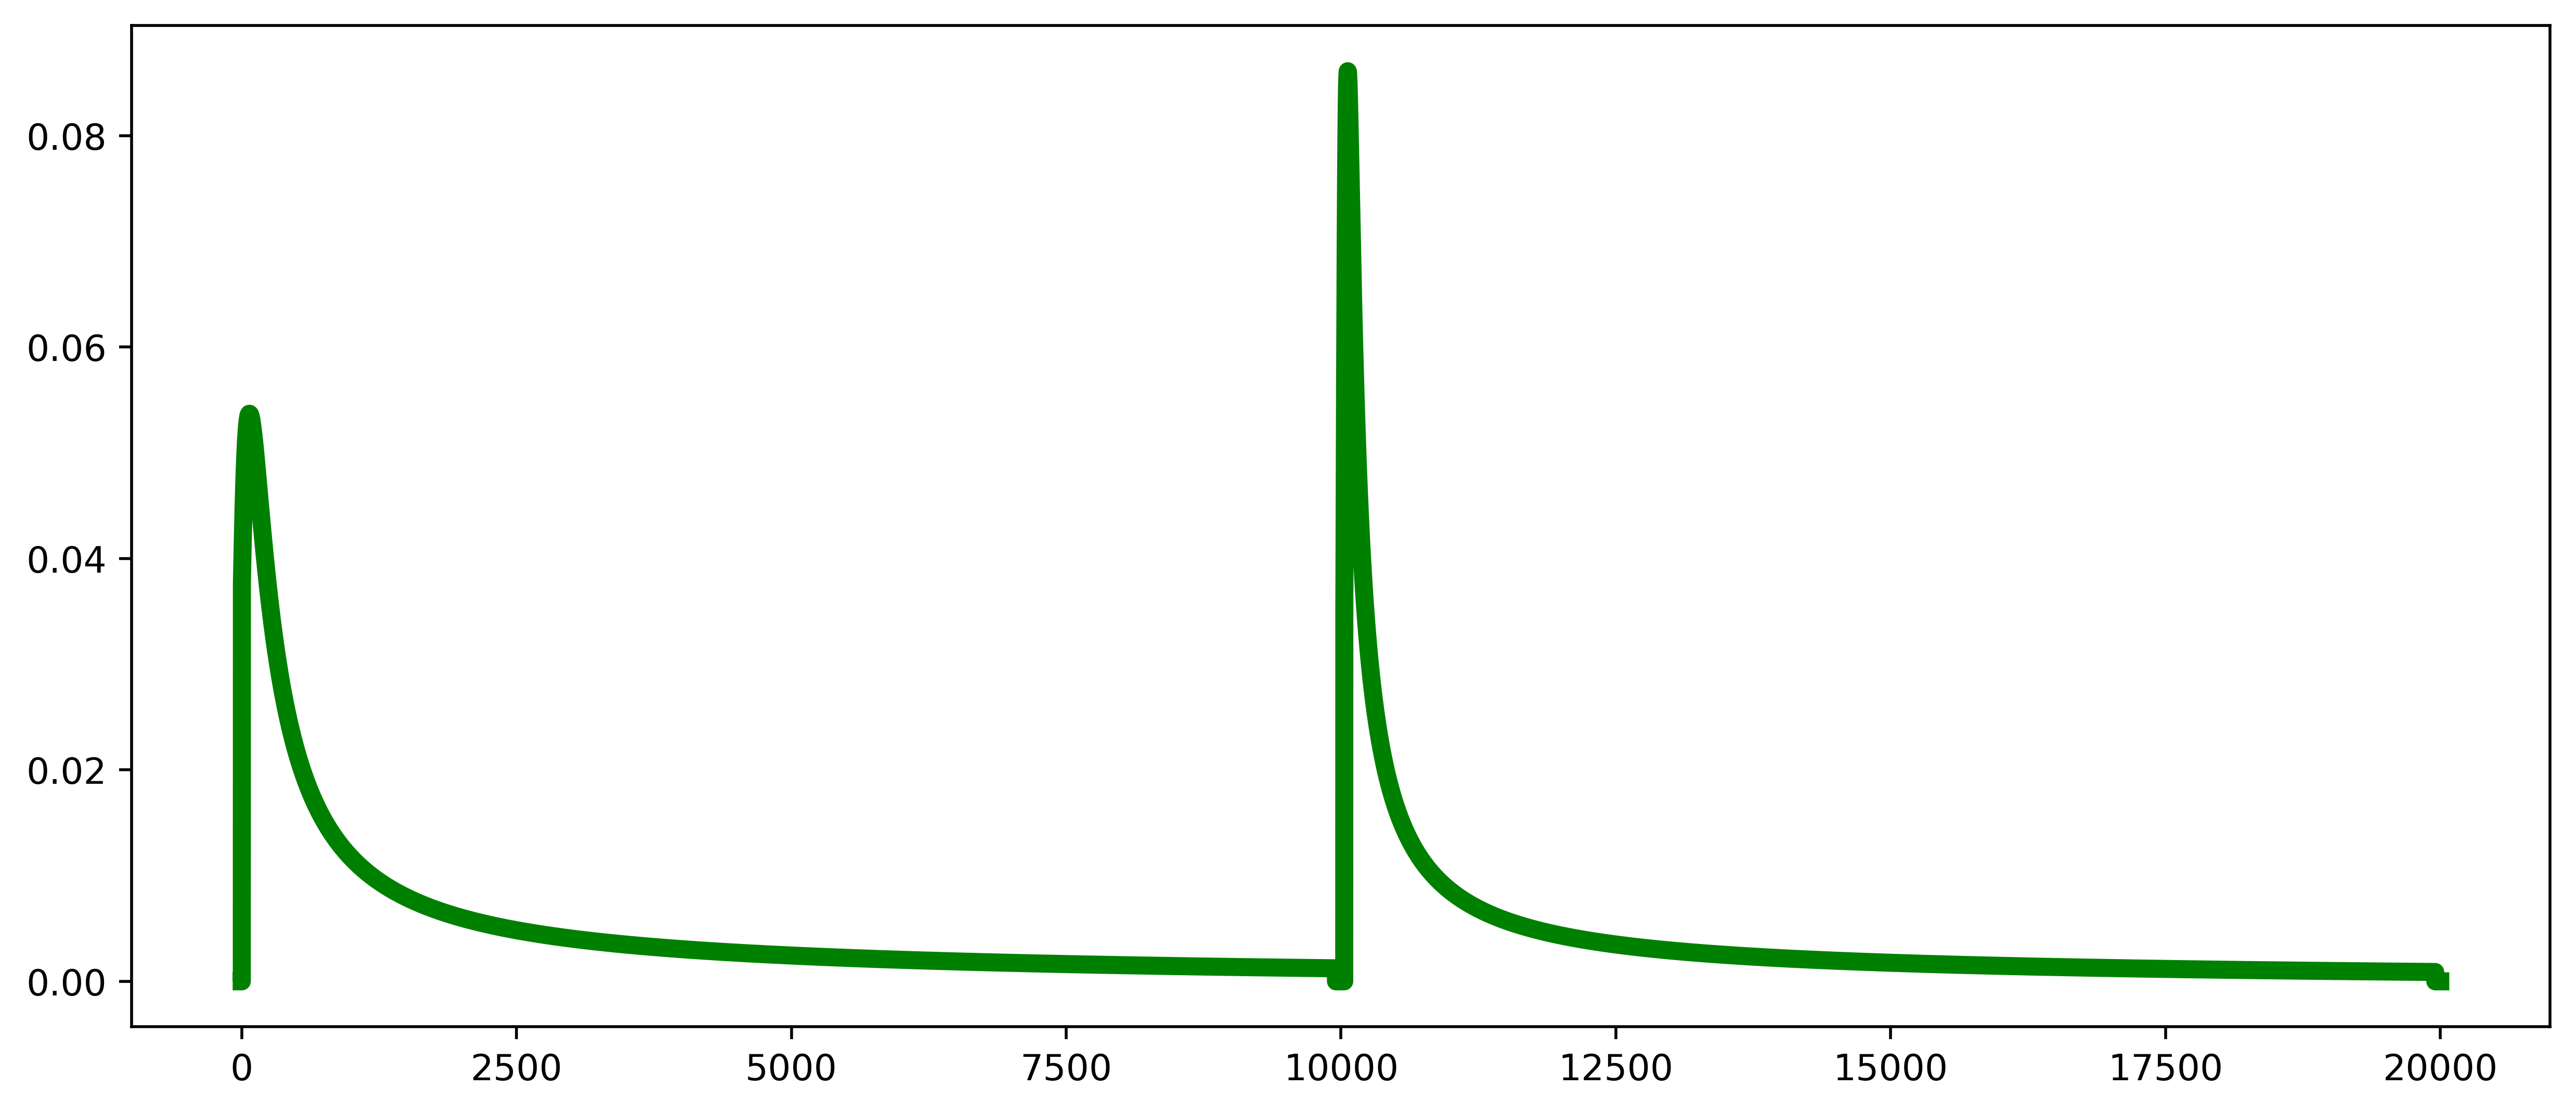

In [ ]:
plt.figure(figsize=(12,5),dpi=500,)
plt.plot(testx.to("cpu").detach().numpy()[0][0],'g',linewidth=5)


In [ ]:
pred.shape

(20000,)

In [ ]:
max(pred[0]) - max(testx.to("cpu").detach().numpy()[0][0])

0.006811003659158307

In [ ]:
max(pred[1]) - max(testx.to("cpu").detach().numpy()[0][1])

0.0008766075186765754

## Localizer

### FC
#### Best
```
class localization_model(nn.Module):
  def __init__(self):
    super(localization_model, self).__init__()
    self.localizer = nn.Sequential(
        nn.Linear(2*10000,750),
        nn.ReLU(),
        nn.Linear(750,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),

        nn.Linear(256,2),
    )

  def forward(self,x):
    x = x.reshape((-1,))
    y = self.localizer(x)
    return y

localize_model = localization_model().to(device)
print(localize_model)
```

In [ ]:
class localization_model(nn.Module):
  def __init__(self):
    super(localization_model, self).__init__()
    self.localizer = nn.Sequential(
        nn.Linear(39972,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,128),
        nn.ReLU(),

        nn.Linear(128,2),
    )

  def forward(self,x):
    x = x.reshape((-1,))
    y = self.localizer(x)
    return y

localize_model = localization_model().to(device)
print(localize_model)

localization_model(
  (localizer): Sequential(
    (0): Linear(in_features=39972, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


### CNN

In [ ]:
class localization_model(nn.Module):
  def __init__(self):
    super(localization_model, self).__init__()
    self.conv_L1 = nn.Sequential(
        nn.Conv1d(4,4,2),
        nn.ReLU(),
        nn.MaxPool1d(3),
    )

    self.flat = nn.Flatten()
    self.fc = nn.Sequential(
        nn.Linear(1664,400),
        nn.ReLU(),
        nn.Linear(400,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),


        nn.Linear(128,2),
    )

  def forward(self,x):
    x = self.conv_L1(x)
    x = self.flat(x)
    y = self.fc(x)
    return y

localize_model = localization_model().to(device)
print(localize_model)

localization_model(
  (conv_L1): Sequential(
    (0): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=1664, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


### Train

In [ ]:
auto_encoder = Auto_Encoder().to(device)
auto_encoder.load_state_dict(torch.load("best_autoencoder_model.pth"))

<All keys matched successfully>

In [ ]:
learning_rate = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(localize_model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [ ]:
def train_localizer(dataloader, model, loss_fn, oprimizer,scheduler):
    size = len(dataloader.dataset)
    model.train()

    for batch , (X,y)  in enumerate(dataloader):
        # y = y.reshape((16,2))
        encode,_ = auto_encoder(X.float())
        pred = model(encode)
        #pred = model(X.float())
        loss = loss_fn(pred, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%1000 ==0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()
    return loss

def test_localizer(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch , (X,y)  in enumerate(dataloader):
            # y = y.reshape((16,2))
            encode,_ = auto_encoder(X.float())
            pred = model(encode)
            #pred = model(X.float())
            test_loss += loss_fn(pred, y.float()).item()
            #print(pred.argmax(0),y)
    test_loss /= num_batches
    print(f"Test Error:  Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
epochs = 150
train_losses, test_losses = [], []
for i in range(epochs):
    print(f"Epoch {i+1} \n" ,"-"*30)
    train_loss=train_localizer(train_dataloader, localize_model, loss_fn, optimizer,exp_lr_scheduler)
    test_loss=test_localizer(test_dataloader, localize_model, loss_fn)

    train_losses.append(train_loss.to("cpu").detach().numpy())
    test_losses.append(test_loss)

    if test_loss <= min(test_losses):
      torch.save(localize_model.state_dict(), '/content/drive/MyDrive/lightning-localization/best_localize_model.pth')
      print("Saved PyTorch Model State to best_localize_model.pth")
    else: pass
    # if i == 40:
    #   exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    # else: pass

Epoch 1 
 ------------------------------
loss: 59802784.000000  [    0/ 8000]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 446672832.000000  [ 1000/ 8000]
loss: 39068148.000000  [ 2000/ 8000]
loss: 38215116.000000  [ 3000/ 8000]
loss: 368718592.000000  [ 4000/ 8000]
loss: 398879872.000000  [ 5000/ 8000]
loss: 567971072.000000  [ 6000/ 8000]
loss: 15447032.000000  [ 7000/ 8000]
Test Error:  Avg loss: 70682694.727873 

Saved PyTorch Model State to best_localize_model.pth
Epoch 2 
 ------------------------------
loss: 5038930.500000  [    0/ 8000]
loss: 284433536.000000  [ 1000/ 8000]
loss: 1751726.000000  [ 2000/ 8000]
loss: 3755956.500000  [ 3000/ 8000]
loss: 59509752.000000  [ 4000/ 8000]
loss: 103013632.000000  [ 5000/ 8000]
loss: 107101744.000000  [ 6000/ 8000]
loss: 7285443.000000  [ 7000/ 8000]
Test Error:  Avg loss: 54660701.204904 

Saved PyTorch Model State to best_localize_model.pth
Epoch 3 
 ------------------------------
loss: 30162904.000000  [    0/ 8000]
loss: 19010844.000000  [ 1000/ 8000]
loss: 786730.312500  [ 2000/ 8000]
loss: 619121.375000  [ 3000/ 8000]
loss: 19582408.000000  [ 400

In [ ]:
min(test_losses)

87378.4519683628

Text(0.5, 1.0, 'Localizer Model Loss')

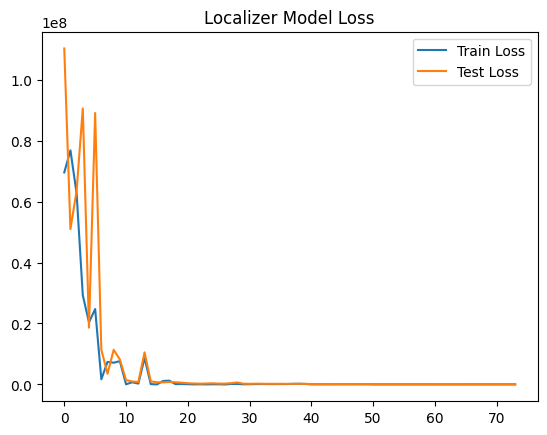

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["Train Loss", "Test Loss"])
plt.title("Localizer Model Loss")

In [ ]:
localize_model.load_state_dict(torch.load("/content/drive/MyDrive/lightning-localization/best_localize_model.pth"))

<All keys matched successfully>

In [ ]:
pred_list_y,test_list_y = [],[]
pred_list_x,test_list_x = [],[]
for batch , (X,y)  in enumerate(test_dataloader):
  encode,_ = auto_encoder(X.float())
  pred = localize_model(encode)
  #pred = localize_model(X.float())
  pred_list_x.append(pred.to('cpu').to("cpu").detach().numpy()[0])
  test_list_x.append(y.to('cpu').to("cpu").detach().numpy()[0][0])

  pred_list_y.append(pred.to('cpu').to("cpu").detach().numpy()[1])
  test_list_y.append(y.to('cpu').to("cpu").detach().numpy()[0][1])

In [ ]:
print("y: ",np.corrcoef(pred_list_y,test_list_y)[0][1])

y:  0.9997822625084861


In [ ]:
print("x: ",np.corrcoef(pred_list_x,test_list_x)[0][1])

x:  0.9998821465871433


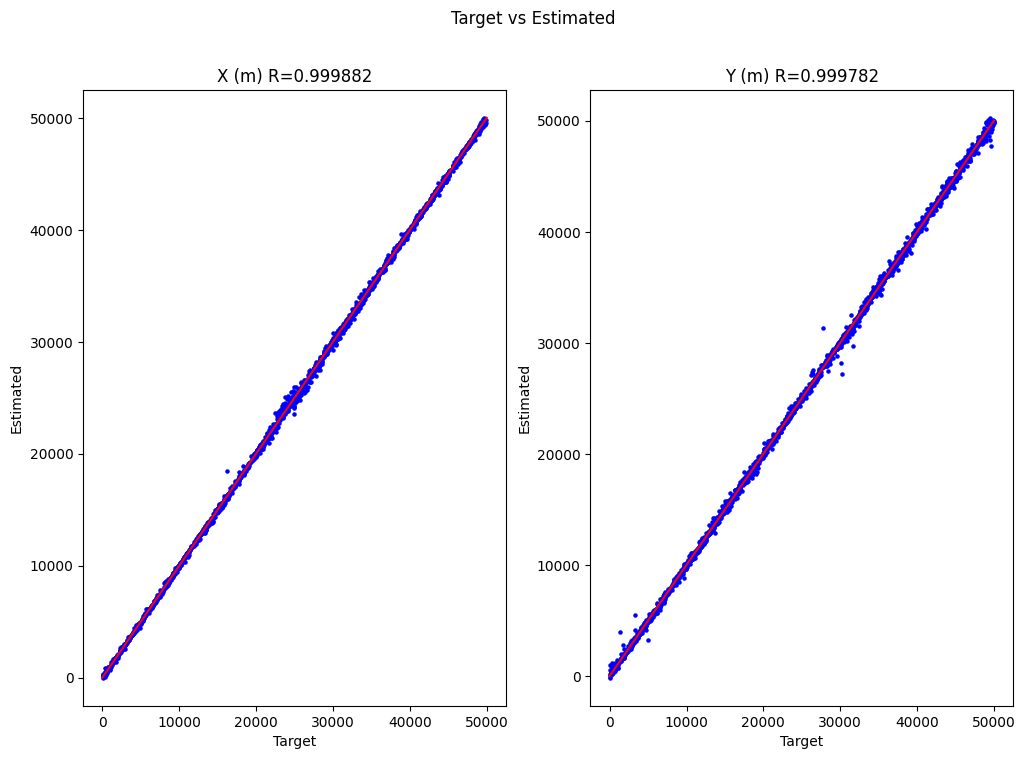

In [ ]:
perfect_line = np.arange(50000)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(perfect_line,perfect_line,'r')
plt.scatter(test_list_x,pred_list_x,c='b',s=5)
plt.xlabel("Target")
plt.ylabel("Estimated")
plt.title(f"X (m) R={np.corrcoef(pred_list_x,test_list_x)[0][1]:5f}")
plt.text(x=0, y=50000,)


plt.subplot(122)
plt.plot(perfect_line,perfect_line,'r')
plt.scatter(test_list_y,pred_list_y,c='b',s=5)
plt.xlabel("Target")
plt.ylabel("Estimated")
plt.title(f"Y (m) R={np.corrcoef(pred_list_y,test_list_y)[0][1]:5f}")
plt.suptitle("Target vs Estimated")

plt.savefig("/content/drive/MyDrive/lightning-localization/target_vs_estimate2.png",
                    format='png',dpi=500)

In [ ]:
pred[0]

tensor(32637.8867, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
x_pred_real=np.concatenate((np.array(pred_list_x).reshape(1,-1),
               y_test.to('cpu').to("cpu").detach().numpy()[:,0].reshape(1,-1)),axis=0)
y_pred_real=np.concatenate((np.array(pred_list_y).reshape(1,-1),
               y_test.to('cpu').to("cpu").detach().numpy()[:,1].reshape(1,-1)),axis=0)

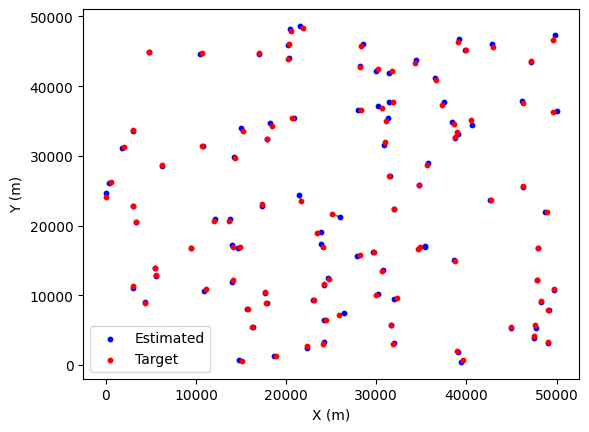

In [ ]:

plt.plot(x_pred_real[:,:100],y_pred_real[:,:100],'grey',zorder=-1)
plt.scatter(pred_list_x[:100],pred_list_y[:100],c='b',s=10, label = "Estimated")
plt.scatter(y_test.to('cpu').to("cpu").detach().numpy()[:100,0],
            y_test.to('cpu').to("cpu").detach().numpy()[:100,1],c='r',s=10,label= "Target")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()

plt.savefig("/content/drive/MyDrive/lightning-localization/target_vs_estimate_location.png",
                    format='png',dpi=500)

In [ ]:
x_pred_real[:,:25].shape

In [ ]:
plt.scatter(y_test.to('cpu').to("cpu").detach().numpy()[:,0],
            y_test.to('cpu').to("cpu").detach().numpy()[:,1])

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor


In [ ]:
regr = XGBRegressor(max_depth=30,n_jobs=4)
regr =MultiOutputRegressor(regr)
regr = regr.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
np.sqrt(mean_squared_error(test_list_x, pred_list_x))

219.49101326298396

In [ ]:
np.sqrt(mean_squared_error(test_list_y, pred_list_y))

307.2959970187758

In [ ]:
target.shape

(10000, 1, 2)